# Breast Tumour Segmentation with the U-net Architecture

###Aim
- The aim of this project is to successfully segment different types of breast tumours from 2D CT-scan images.
*  The model proposed is a 5 layered u-net model
*  My results show an average dice score of 90%



##Data Preparation and Preprocessing

In [ ]:
from tensorflow import keras

In [ ]:
import cv2
from matplotlib import pyplot as plot
import numpy as np
from pathlib import Path
from google.colab import drive
import tensorflow as tf

In [ ]:
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
#Collecting paths for images and truth values
normal = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/normal/images/').iterdir())
normal_masks = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/normal/masks/').iterdir())

benign = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/benign/images/').iterdir())
benign_masks = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/benign/masks/').iterdir())

malignant = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/malignant/images/').iterdir())
malignant_masks = list(Path(r'gdrive/MyDrive/Dataset_BUSI_with_GT/malignant/masks/').iterdir())

normal.sort(reverse=True)
normal_masks.sort(reverse=True)

benign.sort(reverse=True)
benign_masks.sort(reverse=True)

malignant.sort(reverse=True)
malignant_masks.sort(reverse=True)

for i in malignant_masks:
  if  'mask_' in str(i):
    malignant_masks.remove(i)


for i in benign_masks:
  if  'mask_' in str(i):
    benign_masks.remove(i)

benign_masks.remove(benign_masks[330])



print(len(malignant),len(malignant_masks))
print(len(benign),len(benign_masks))
print(len(normal))

210 210
437 437
133


In [ ]:
#FUNCTION TO COVERT NORMALISE IMAGE PIXELS BETWEEN 0 and 1
def binarize(matrix):
    matrix = np.round(matrix/255)*255
    return matrix

In [ ]:
#Using collected paths
images = []
target = []

for i in range(210):
    m = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    mm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(malignant_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(m)
    target.append(binarize(mm))
    
for i in range(437):
    b = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    bm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(benign_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(b)
    target.append(binarize(bm))

for i in range(133):
    n = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    nm = cv2.cvtColor(cv2.resize(cv2.imread(r'{}'.format(normal_masks[i])),(224,224)),cv2.COLOR_BGR2GRAY)
    images.append(n)
    target.append(binarize(nm))
    
    

In [ ]:
x = np.array(images)
x = x / 255
y = np.array(target)
y = y / 255

In [ ]:
len(y)

780

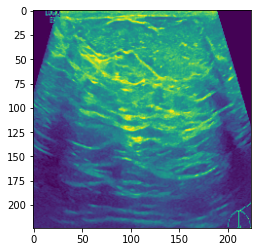

In [ ]:
plot.imshow(x[19])

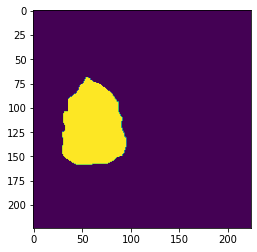

In [ ]:
plot.imshow(y[19])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtr,xte,ytr,yte = train_test_split(x,y,test_size=0.2)

In [ ]:
from tensorflow import keras

In [ ]:
#DICE METRIC
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

## Model Training

#UNET Architecture(4 levels)



1.   binary focal crossentropy loss
2.   100 epochs
3.   92% training dice score, 64% test dice score



In [ ]:
inputs = keras.layers.Input((224,224,1))

# Convolution + Max Pooling

conv1 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(inputs)
conv11 = keras.layers.Conv2D(32,2,padding='same',activation='relu')(conv1)
pool1 = keras.layers.MaxPool2D((2,2))(conv11)

# Convolution + Max Pooling
conv2 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(pool1)
conv21 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(conv2)
pool2 = keras.layers.MaxPool2D((2,2))(conv21)

# Convolution + Max Pooling

conv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(pool2)
conv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(conv3)
pool3 = keras.layers.MaxPool2D((2,2))(conv31)

conv4 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(pool3)
conv41 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(conv4)
pool4 = keras.layers.MaxPool2D((2,2))(conv41)


upsample2 = keras.layers.UpSampling2D((2,2))(pool4)
#end
uconv2 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(upsample2)
merge2 = keras.layers.Concatenate()([conv41,uconv2])
uconv21 =  keras.layers.Conv2D(256,3,padding='same',activation='relu')(merge2)

upsample3 = keras.layers.UpSampling2D((2,2))(uconv21)

uconv3 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(upsample3)
merge3 = keras.layers.Concatenate()([conv31,uconv3])
uconv31 =  keras.layers.Conv2D(128,3,padding='same',activation='relu')(merge3)

upsample4 = keras.layers.UpSampling2D((2,2))(uconv31)

uconv4=  keras.layers.Conv2D(64,3,padding='same',activation='relu')(upsample4)
merge4 = keras.layers.Concatenate()([conv21,uconv4])
uconv41 =  keras.layers.Conv2D(64,3,padding='same',activation='relu')(merge4)

upsample5 = keras.layers.UpSampling2D((2,2))(uconv41)

uconv5=  keras.layers.Conv2D(32,3,padding='same',activation='relu')(upsample5)
merge5 = keras.layers.Concatenate()([conv11,uconv5])
uconv51 =  keras.layers.Conv2D(32,3,padding='same',activation='relu')(merge5)


output =  keras.layers.Conv2D(1,1,padding='same',activation='sigmoid')(uconv51)

unet = keras.models.Model(inputs=inputs,outputs=output)
unet.compile(
    optimizer = 'adam',
    metrics = [dice_metric],
    loss='binary_focal_crossentropy'
)
unet.fit(xtr,ytr,epochs=100,validation_data=(xte,yte))

Epoch 1/100
20/20 [==============================] - 14s 603ms/step - loss: 0.1176 - dice_metric: 0.1227 - val_loss: 0.0780 - val_dice_metric: 0.1307
Epoch 2/100
20/20 [==============================] - 9s 448ms/step - loss: 0.0739 - dice_metric: 0.1236 - val_loss: 0.0755 - val_dice_metric: 0.1294
Epoch 3/100
20/20 [==============================] - 9s 447ms/step - loss: 0.0736 - dice_metric: 0.1260 - val_loss: 0.0754 - val_dice_metric: 0.1298
Epoch 4/100
20/20 [==============================] - 9s 451ms/step - loss: 0.0722 - dice_metric: 0.1231 - val_loss: 0.0759 - val_dice_metric: 0.1348
Epoch 5/100
20/20 [==============================] - 9s 451ms/step - loss: 0.0701 - dice_metric: 0.1314 - val_loss: 0.0799 - val_dice_metric: 0.1384
Epoch 6/100
20/20 [==============================] - 9s 455ms/step - loss: 0.0668 - dice_metric: 0.1427 - val_loss: 0.0672 - val_dice_metric: 0.1610
Epoch 7/100
20/20 [==============================] - 9s 453ms/step - loss: 0.0603 - dice_metric: 0.1679 -

In [ ]:
unet.evaluate(xte,yte)

5/5 [==============================] - 1s 146ms/step - loss: 0.2007 - dice_metric: 0.6462


[0.20074233412742615, 0.6462496519088745]

# Model testing/Examples

1/1 [==============================] - 0s 18ms/step


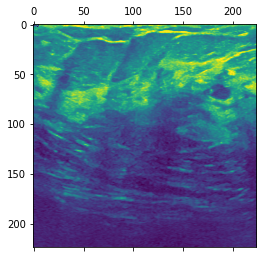

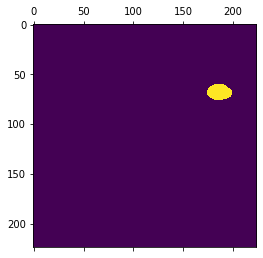

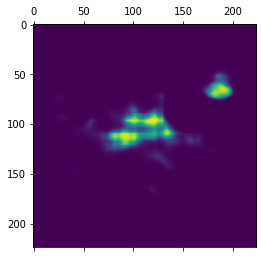

In [ ]:
 def plot_test(index,categorical=False):
  plot.matshow(xte[index])
  yp = unet.predict(xte[index].reshape(1,224,224))
  plot.matshow(yte[index])
  plot.matshow(yp.reshape(224,224))



plot_test(8)

1/1 [==============================] - 0s 23ms/step


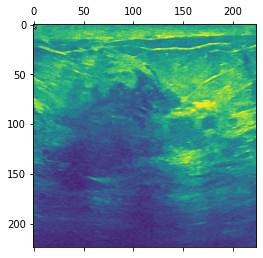

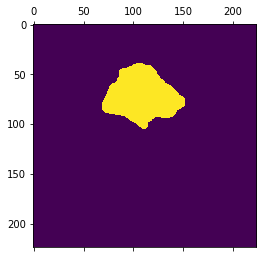

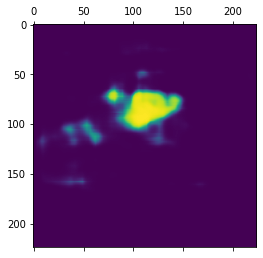

In [ ]:
plot_test(14)

1/1 [==============================] - 0s 17ms/step


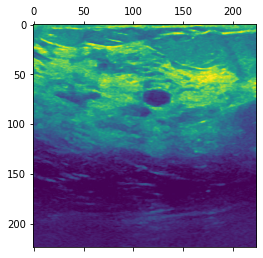

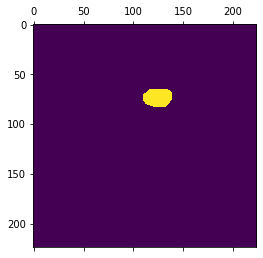

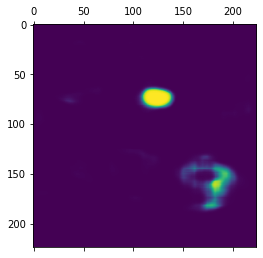

In [ ]:
plot_test(19)

1/1 [==============================] - 0s 17ms/step


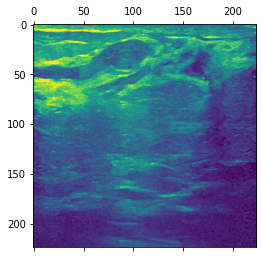

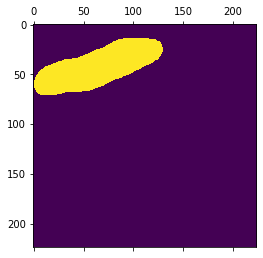

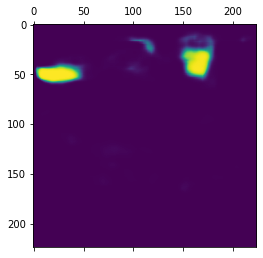

In [ ]:
plot_test(11)

1/1 [==============================] - 0s 23ms/step


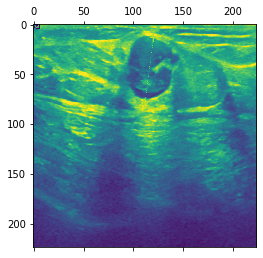

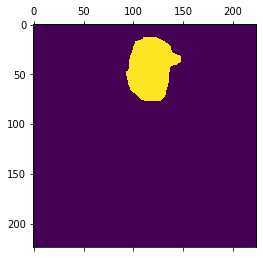

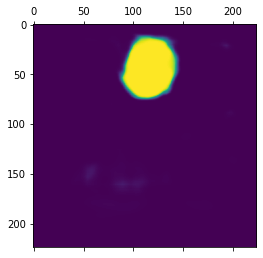

In [ ]:
plot_test(13)

1/1 [==============================] - 0s 18ms/step


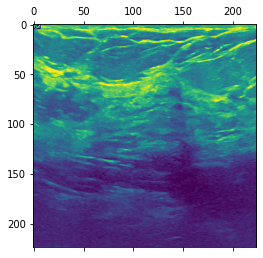

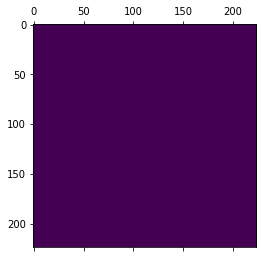

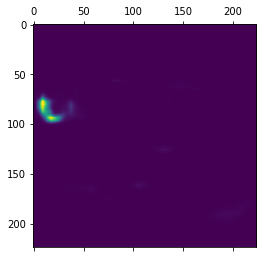

In [ ]:
plot_test(15)

1/1 [==============================] - 0s 17ms/step


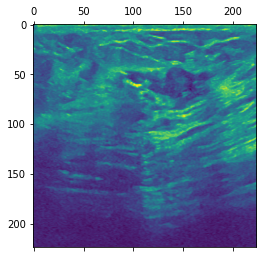

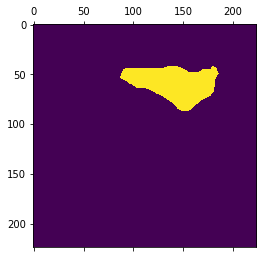

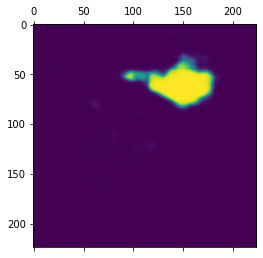

In [ ]:
plot_test(16)

1/1 [==============================] - 0s 16ms/step


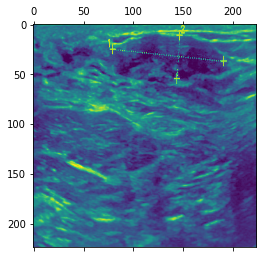

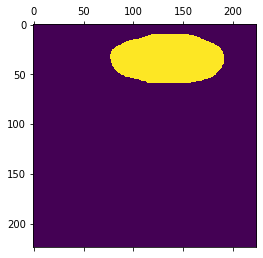

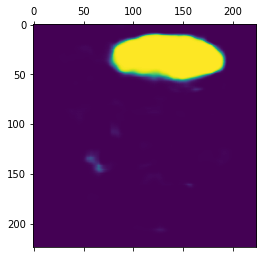

In [ ]:
plot_test(17)

1/1 [==============================] - 0s 18ms/step


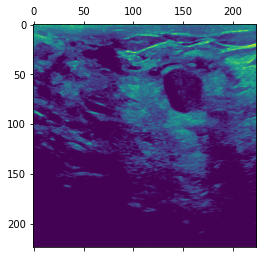

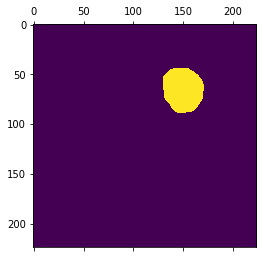

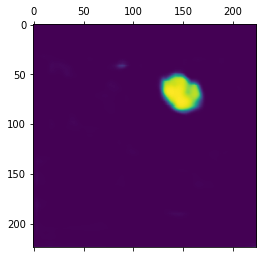

In [ ]:
plot_test(10)

1/1 [==============================] - 0s 17ms/step


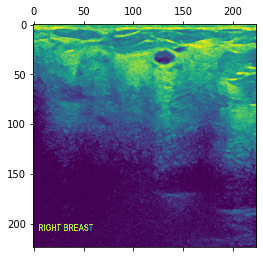

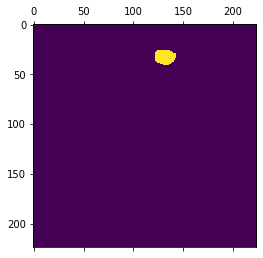

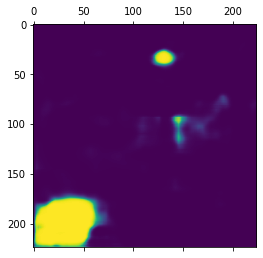

In [ ]:
plot_test(29)

1/1 [==============================] - 0s 29ms/step


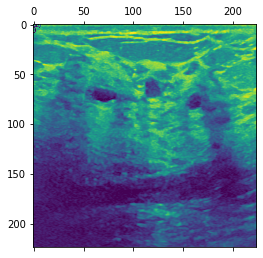

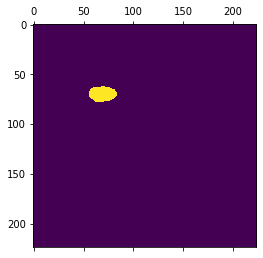

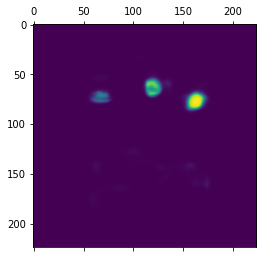

In [ ]:
plot_test(34)

1/1 [==============================] - 0s 17ms/step


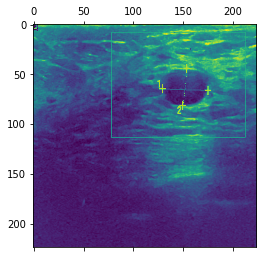

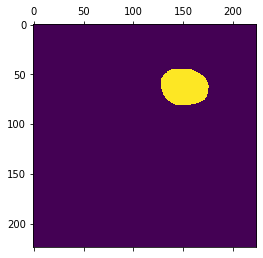

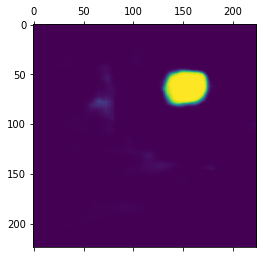

In [ ]:
plot_test(33)

# Key Insights

- The model is really good as identifying isolated/exposed tumours 
- The model is good at getting the shape of the the tumour but lacks the fine outlines on the prediction
-  The model fails to identify tumours partially hidden by tissue. This is evident in plot_test(11)
- The model also mistakens writings or drawings as an indication of a tumour. This is evident in plot_test (29)
- The model to generally overfits to the training images
